# Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install pandas numpy jax sklearn selfies rdkit exmol kdeepensemble tqdm padelpy pyyaml h5py
!pip install -q tensorflowjs
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 2.3 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=37aedbafe5a2647ecb0d75f7a0c4eb888fb2f547bba8e3a9936a0e076d72cbac
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5909 sha256=f580b56392c12a23b366badf2041e269c99e8adc35c1ef169de9f12ba877e9ce
  Stored in directory: /root/.cache/pip/wheels/8e/34/5e/1dd3d652594bdf5df01109a683a

In [3]:
# regular libraries
import pandas as pd
import numpy as np
import os

# ML
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflowjs as tfjs
import kdens

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from rdkit.Chem.Descriptors import MolWt, NumValenceElectrons
from rdkit.Chem.Crippen import MolLogP, MolMR
from rdkit.Chem.Lipinski import (HeavyAtomCount,
                                NumHAcceptors,
                                NumHDonors,
                                NumHeteroatoms,
                                NumRotatableBonds,
                                NumAromaticRings,
                                NumSaturatedRings,
                                NumAliphaticRings,
                                RingCount
                                )
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcLabuteASA
from rdkit.Chem.GraphDescriptors import BalabanJ, BertzCT
from rdkit.Chem import MolFromSmiles

# Utils
import selfies as sf
import exmol
import urllib
from dataclasses import dataclass
import json
np.random.seed(0)

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True
           })

# Getting data

In [4]:
# path = "/content/drive/MyDrive/WhiteLab/sol-nn/ml"
!unzip data.zip
path = "."

with open(f"{path}/voc.json", 'r') as inp:
  voc = json.load(inp)

Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/ESOL.csv           
  inflating: __MACOSX/data/._ESOL.csv  
  inflating: data/padelAqSolDB.csv   
  inflating: __MACOSX/data/._padelAqSolDB.csv  
   creating: data/.ipynb_checkpoints/
  inflating: __MACOSX/data/._.ipynb_checkpoints  
  inflating: data/SolChal2-2.csv     
  inflating: __MACOSX/data/._SolChal2-2.csv  
  inflating: data/SolChal2-1.csv     
  inflating: __MACOSX/data/._SolChal2-1.csv  
  inflating: data/SolChal1.csv       
  inflating: __MACOSX/data/._SolChal1.csv  
  inflating: data/curated-solubility-dataset.csv  
  inflating: __MACOSX/data/._curated-solubility-dataset.csv  


## Getting AqSolDB and aug_AqSolDB

In [5]:
# Is this link reliable?
# !wget -cO - https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/OVHAW8/RLVXZU > AqSolDB.tsv
# AqSolDB = pd.read_csv("AqSolDB.tsv", sep="\t")

AqSolDB = pd.read_csv(f"{path}/data/curated-solubility-dataset.csv")
AqSolDB2 = pd.read_csv(f"{path}/data/padelAqSolDB.csv")

descriptors = AqSolDB.iloc[:, 9:]
labels = AqSolDB["Solubility"]

print(f"The model has {len(AqSolDB)} unique entries.")

The model has 9982 unique entries.


## Getting Solubility Challenge data

In [6]:
SolChal1   = pd.read_csv(f"{path}/data/SolChal1.csv")
# sSolChal1  = pd.read_csv(f"{path}/data/SolChal1.csv") # backup df to analyze NaN entries
SolChal2_1 = pd.read_csv(f"{path}/data/SolChal2-1.csv")
SolChal2_2 = pd.read_csv(f"{path}/data/SolChal2-2.csv")

# SolChal1 = SolChal1.dropna(how="all", axis=0)

In [7]:
def calcS0(entry):
  try:
    return np.log10(1e-3*entry["expSolubility"]/MolWt(MolFromSmiles(entry["SMILES"])))
  except:
    return None

SolChal1["Solubility"] = SolChal1.apply(calcS0, axis=1)

In [8]:
#Checking for challenge molecules on training dataset
match = []
for s in pd.concat([SolChal1, SolChal2_1, SolChal2_2], axis=0)["SMILES"]:
  for a in AqSolDB["SMILES"]:
    if (a==s):
      match.append(s)

print(f"There are {'' if match else 'no'} matches between AqSolDB and the Challenges")

There are no matches between AqSolDB and the Challenges


## Getting ESOL data

In [9]:
ESOL = pd.read_csv(f"{path}/data/ESOL.csv")
ESOL = ESOL.rename({"measured log(solubility:mol/L)": "Solubility"}, axis=1)

# Analysing

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

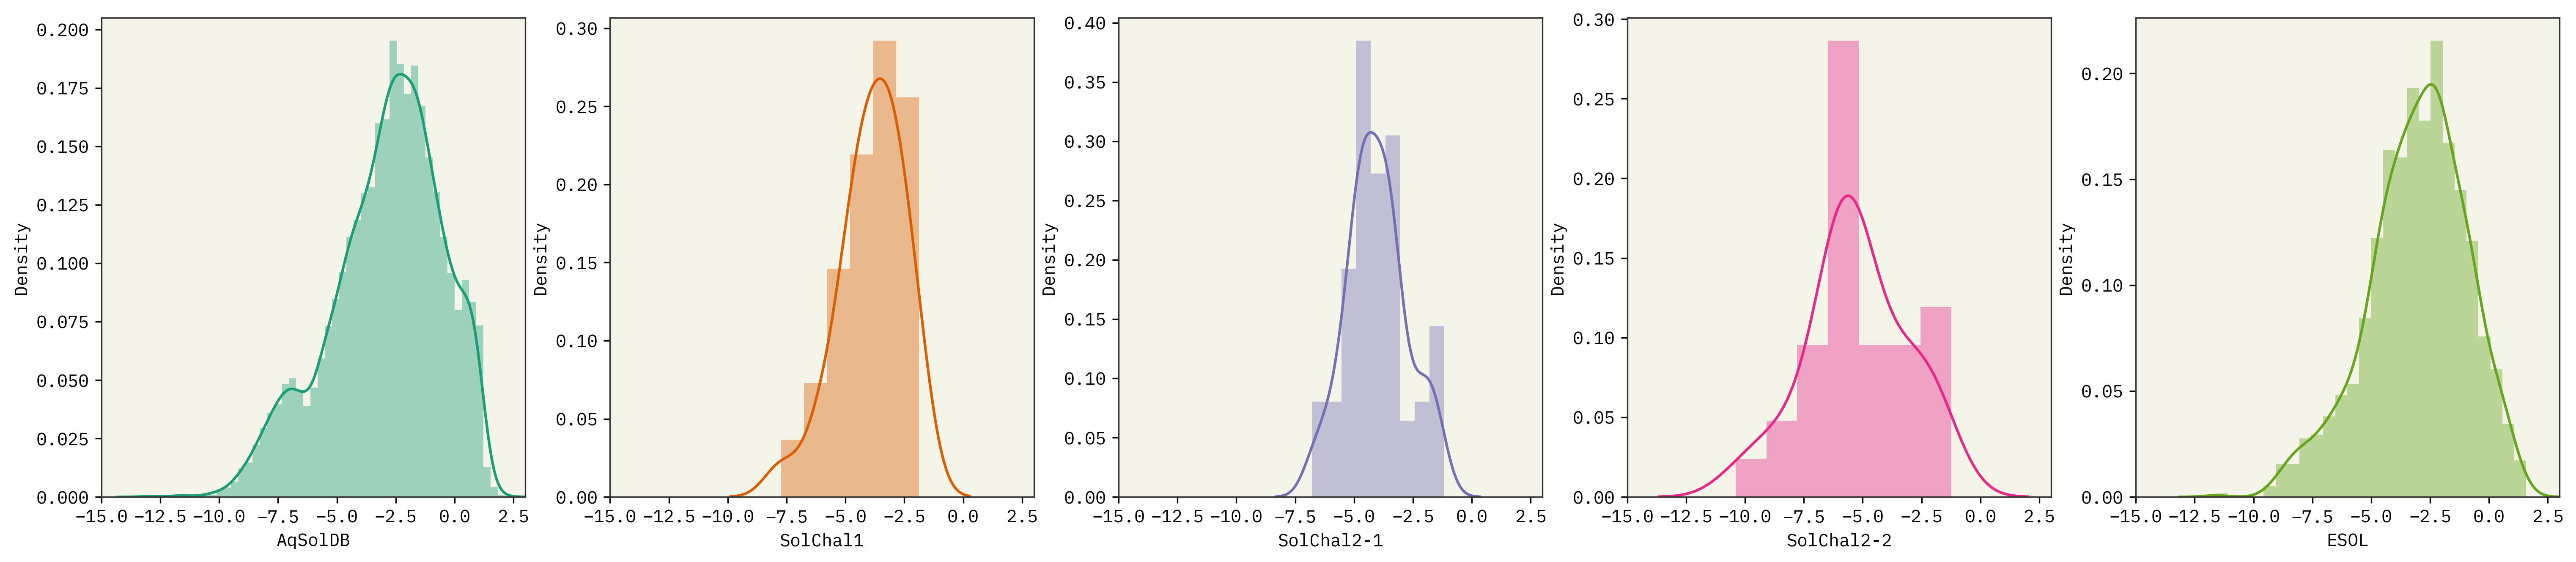

In [10]:
y = AqSolDB["Solubility"]

ys = pd.DataFrame({
    "AqSolDB": AqSolDB["Solubility"],
    "SolChal1": SolChal1["Solubility"],
    "SolChal2-1": SolChal2_1["Solubility"],
    "SolChal2-2": SolChal2_2["Solubility"],
    "ESOL" : ESOL["Solubility"]
})

fig, axs = plt.subplots(ncols=5, figsize=(25,5), dpi=300)
for i, (name, y) in enumerate(ys.items()):
  # sns.histplot(y, ax=axs[i], color=f"C{i}")
  # sns.histplot(y, ax=axs[i], color=f"black", element="poly", fill=False)
  sns.distplot(y, ax=axs[i], color=f"C{i}")
  axs[i].set_xlim(-15,3)


# Cleaning up

In [11]:
df = AqSolDB[:]

# Random Forest

### Treating data

In [15]:
df_AqSolDB = AqSolDB2.copy().drop(columns=["TPSA.1"])
df_SolChal1 = SolChal1.copy()
df_SolChal2_1 = SolChal2_1.copy()
df_SolChal2_2 = SolChal2_2.copy()

df_SolChal1 = df_SolChal1[0:32]

In [16]:
def aug_db(df, func_dict):
  for name, func in func_dict.items():
    df[name] = df["SMILES"].map(lambda x: func(MolFromSmiles(x)))


func_dict = {
"MolWt"               : MolWt,
'MolLogP'             : MolLogP,
'MolMR'               : MolMR,
'HeavyAtomCount'      : HeavyAtomCount,
'NumHAcceptors'       : NumHAcceptors,
'NumHDonors'          : NumHDonors,
'NumHeteroatoms'      : NumHeteroatoms,
'NumRotatableBonds'   : NumRotatableBonds,
'NumValenceElectrons' : NumValenceElectrons,
'NumAromaticRings'    : NumAromaticRings,
'NumSaturatedRings'   : NumSaturatedRings,
'NumAliphaticRings'   : NumAliphaticRings,
'RingCount'           : RingCount,
#'TPSA'                : CalcTPSA,
'LabuteASA'           : CalcLabuteASA,
'BalabanJ'            : BalabanJ,
'BertzCT'             : BertzCT,
}

aug_db(df_SolChal1, func_dict)
aug_db(df_SolChal2_1, func_dict)
aug_db(df_SolChal2_2, func_dict)

In [17]:
# SolChal1.to_csv("SolChal1.csv", index=False)
# SolChal2_1.to_csv("SolChal2-1.csv", index=False)
# SolChal2_2.to_csv("SolChal2-2.csv", index=False)

In [18]:
from padelpy import from_smiles
from collections import OrderedDict
import time

def aug_padel(db):
  molDescriptors = []
  for sml in db["SMILES"].to_list():
    try:
      molDescriptors.append( from_smiles(sml, timeout=60) )
    except RuntimeError:
      molDescriptors.append(OrderedDict(
        [(k, np.nan) for k in molDescriptors[0].keys()]
      ))

  descriptorsDict = {k: [] for k in molDescriptors[0].keys()}
  for m in molDescriptors:
    for k in m.keys():
      descriptorsDict[k].append(m[k])

  newDescriptors = pd.DataFrame.from_dict(descriptorsDict)
  return pd.concat([db, newDescriptors.replace({'TPSA.1': 'TPSA'})], axis=1)

df_SolChal1 = aug_padel(df_SolChal1)
df_SolChal2_1 = aug_padel(df_SolChal2_1)
df_SolChal2_2 = aug_padel(df_SolChal2_2)

In [19]:
# df_SolChal1 = aug_padel(df_SolChal1)
# df_SolChal2_1 = aug_padel(df_SolChal2_1)
# df_SolChal2_2 = aug_padel(df_SolChal2_2)

In [20]:
features = df_AqSolDB.columns[9:]
corrs = {k: np.corrcoef(df_AqSolDB["Solubility"], df_AqSolDB[k])[0][1] for k in features}

sorted_corrs = sorted(corrs.items(), key=lambda x: abs(x[1]), reverse=True)
feats = [sorted_corrs[k][0] for k in range(len(features))]

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [21]:
print(df_SolChal1.loc[:,~df_SolChal1.columns.duplicated()][feats].columns)
print(df_AqSolDB[feats].columns)

Index(['MolLogP', 'MolMR', 'MolWt', 'HeavyAtomCount', 'LabuteASA',
       'NumValenceElectrons', 'NumAromaticRings', 'RingCount', 'BertzCT',
       'NumRotatableBonds',
       ...
       'P1s', 'P2s', 'E1s', 'E2s', 'E3s', 'Ts', 'As', 'Vs', 'Ks', 'Ds'],
      dtype='object', length=1891)
Index(['MolLogP', 'MolMR', 'MolWt', 'HeavyAtomCount', 'LabuteASA',
       'NumValenceElectrons', 'NumAromaticRings', 'RingCount', 'BertzCT',
       'NumRotatableBonds',
       ...
       'P1s', 'P2s', 'E1s', 'E2s', 'E3s', 'Ts', 'As', 'Vs', 'Ks', 'Ds'],
      dtype='object', length=1891)


In [22]:
y = df_AqSolDB["Solubility"]
X = df_AqSolDB[feats]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

### Training

In [28]:
model_name = "XGBoost_RF"

In [29]:
# from sklearn.ensemble import RandomForestRegressor
# m = RandomForestRegressor(
#     n_estimators=100,
#     criterion="squared_error",
#     bootstrap=True,
#     max_depth=None,
#     verbose=False,
# )

In [30]:
import xgboost as xgb
model = xgb.XGBRegressor(
        n_estimators=100,
        objective='reg:squarederror',
)

In [31]:
model.fit(X_train, y_train)

XGBRegressor(objective='reg:squarederror')

In [32]:
model_path = f"{path}/{model_name}"

if not os.path.exists(model_path):
  os.makedirs(f"{model_path}")

model.save_model(f"{model_path}/{model_name}.json")

In [41]:
from google.colab import files
!zip {model_name}.zip {model_name}

files.download(f"{model_name}.zip")

updating: XGBoost_RF/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluating

In [33]:
model_path = f"{path}/{model_name}"

m = xgb.XGBRegressor()
m.load_model(f"{model_path}/{model_name}.json")


In [34]:
def sum_squared_error(y, pred):
  return np.sum((y-pred)**2)

def mse(y, pred):
  return mean_squared_error(y, pred)

def mae(y, pred):
  return mean_absolute_error(y, pred)

def r2(y, pred):
  return r2_score(y, pred)

def corr(y, pred):
  return np.corrcoef(y, pred)[0,1]

def acc(y, pred, threshold):
  acc = sum((abs(pred - y)<threshold))/len(pred)
  return acc


def eval(model, y, X):
  pred=model.predict(X)

  plt.plot(y, y, color='gray')
  plt.plot(y, pred, marker="o", linestyle="", alpha=0.4)
  plt.xlim(min(y), max(y))
  plt.ylim(min(y), max(y))
  plt.xlabel("label LogS")
  plt.ylabel("predicted LogS")
  # plt.text(min(y) + 1, max(y) - 2, f"r-sq = {r2(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 2, f"corr = {corr(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 3, f"RMSE = {np.sqrt(mse(y, pred)):.3f}")
  plt.text(min(y) + 1, max(y) - 4, f"MAE = {mae(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 5, f"acc-1 = {acc(y, pred, 1):.3f}")
  plt.tight_layout()
  plt.savefig(f"{model_path}/{model_name}_eval.png", dpi=300)

Train => MSE:  1.0564
Test  => MSE:  1.4961
Valid => MSE:  1.3658



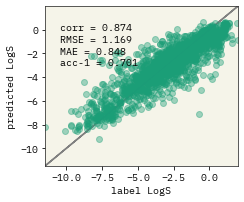

In [35]:
print(f"Train => MSE: {mse(y_train, m.predict(X_train)): 3.4f}")
print(f"Test  => MSE: {mse(y_test, m.predict(X_test)): 3.4f}")
print(f"Valid => MSE: {mse(y_val, m.predict(X_val)): 3.4f}\n")

eval(m, y_val, X_val)

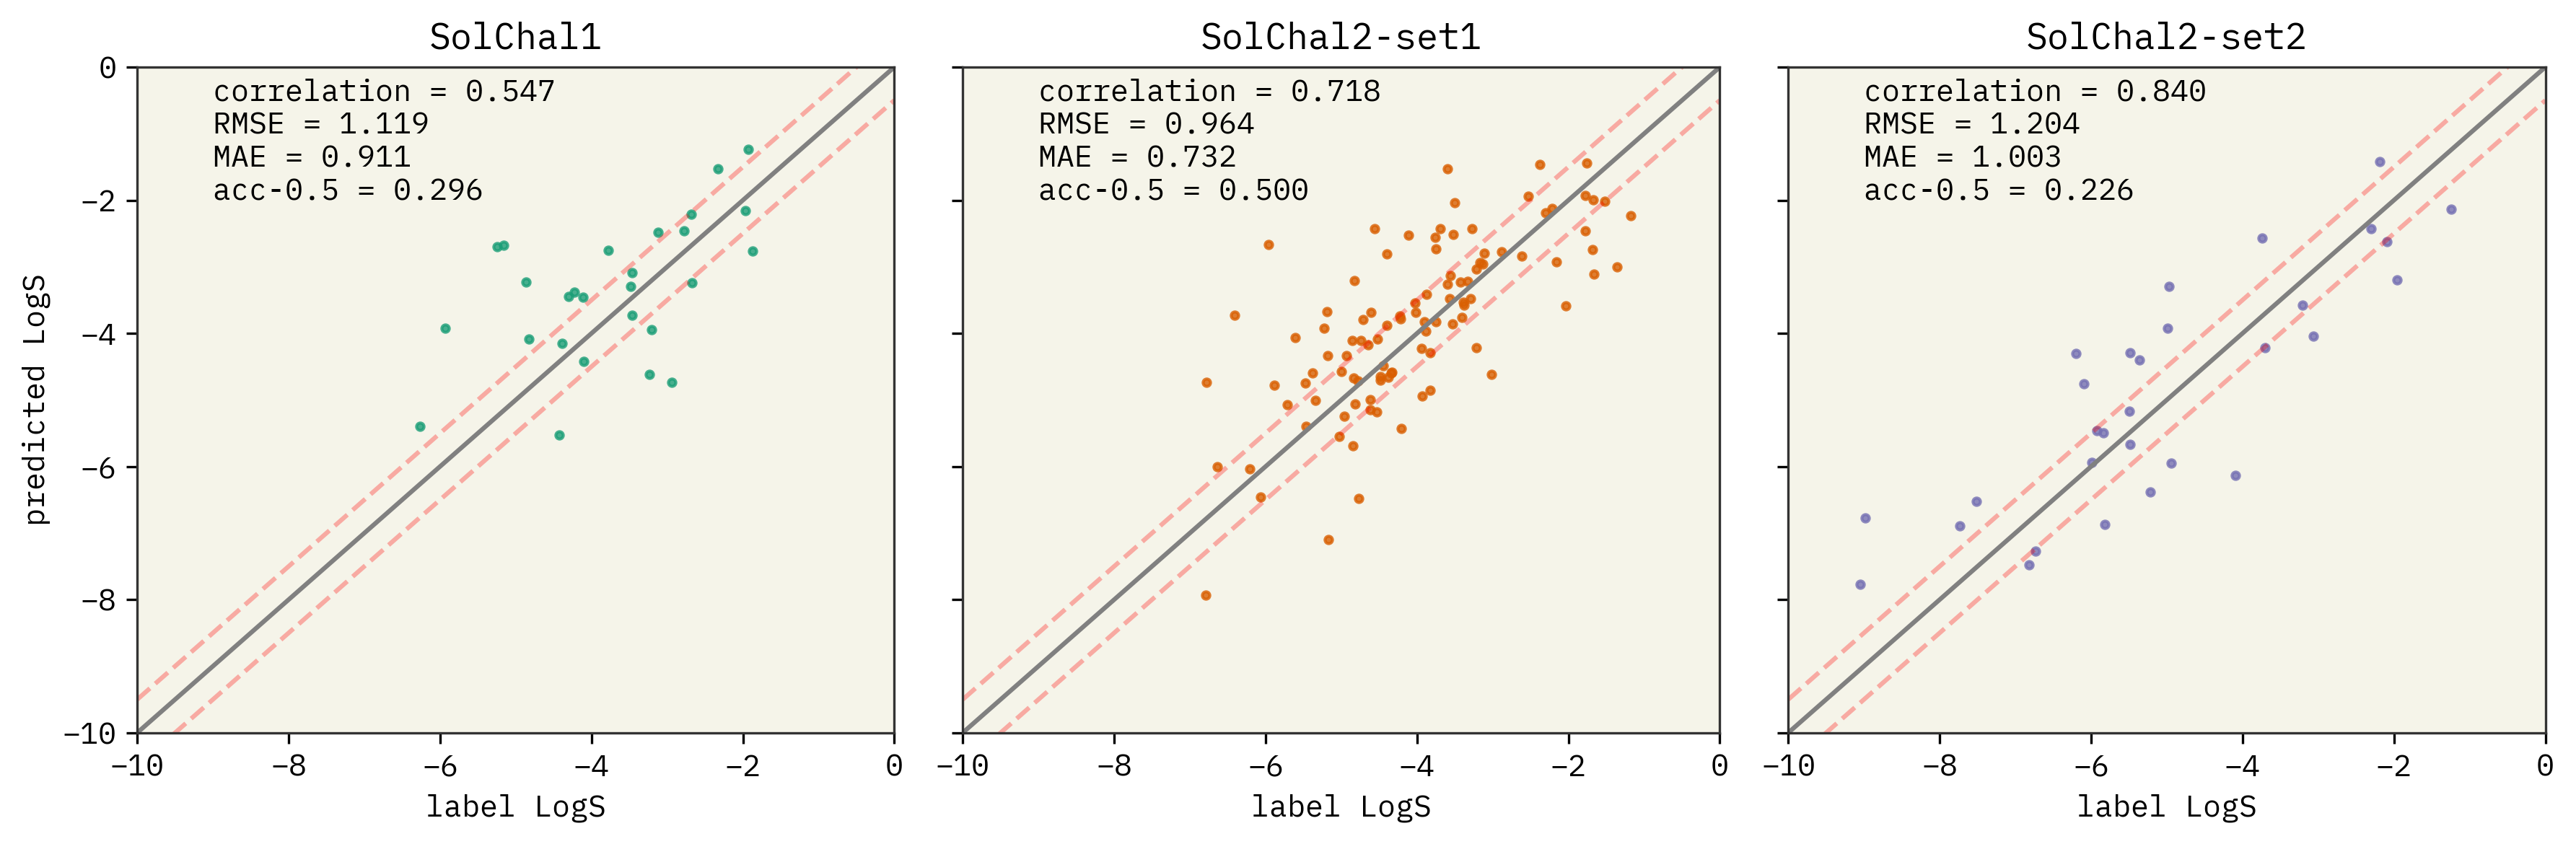

In [36]:
dbs = {"SolChal1":df_SolChal1.loc[:,~df_SolChal1.columns.duplicated()],
       "SolChal2-set1":df_SolChal2_1.loc[:,~df_SolChal2_1.columns.duplicated()],
       "SolChal2-set2":df_SolChal2_2.loc[:,~df_SolChal2_2.columns.duplicated()]
       }

th=0.5

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4), dpi=300)
for i, (name, db) in enumerate(dbs.items()):
  ax = axs[i]
  db = db.dropna(axis=0, how="any")
  y = db["Solubility"]
  X = db[feats]

  X=X.replace('', 0.0)
  X = X.astype(float)

  pred = m.predict(X)
    # ax = axs[i]

  ax.scatter(
      y, pred, s=6, alpha=0.8, color=f"C{i}"
  )

  lim = (-10.0,0.0)
  upper = (lim[0]+th, lim[1]+th)
  lower = (lim[0]-th, lim[1]-th)
  ax.plot(lim,lim, color='gray')
  ax.plot(lim, upper, color='red', alpha=0.3, ls='--')
  ax.plot(lim, lower, color='red', alpha=0.3, ls='--')
  ax.set_title(name)
  # ax.set_xlim([min(y), max(y)])
  # ax.set_ylim([min(y), max(y)])
  ax.set_xlim(lim)
  ax.set_ylim(lim)
  ax.set_xlabel("label LogS")
  if (i==0):
    ax.set_ylabel("predicted LogS")

  # plt.text(min(y) + 1, max(y) - 1, f"correlation = {np.corrcoef(y, pred)[0,1]:.3f}")
  # ax.text(lim[0] + 1, lim[1] - 0.5, f"r-sq = {r2(y, pred):.3f}")
  ax.text(lim[0] + 1, lim[1] - 0.5, f"correlation = {corr(y, pred):.3f}")
  ax.text(lim[0] + 1, lim[1] - 1.0, f"RMSE = {np.sqrt(mse(y, pred)):.3f}")
  ax.text(lim[0] + 1, lim[1] - 1.5, f"MAE = {mae(y, pred):.3f}")
  ax.text(lim[0] + 1, lim[1] - 2.0, f"acc-{th} = {acc(y, pred, th):.3f}")
plt.tight_layout()
plt.savefig(f"{model_path}/{model_name}_solChalDB.png")
plt.show()


                     name  Solubility
5   2-chloromandelic_acid         NaN
11              Ephedrine         NaN
19          Marbofloxacin         NaN
22        Pseudoephedrine         NaN


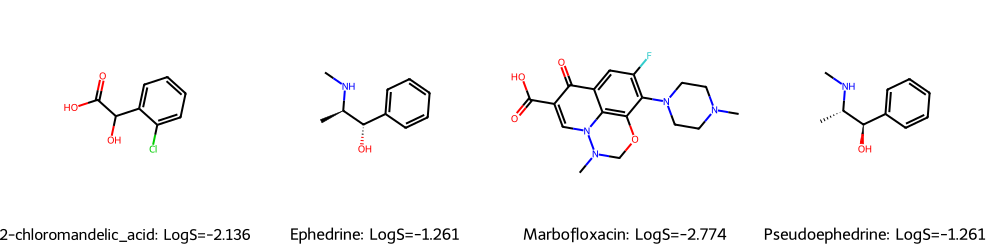

In [37]:
from rdkit.Chem import Draw
from rdkit import Chem
# In SolChal1, some compounds were too soluble:
# 6  2-chloromandelic acid
# 12 1R-2S-ephedrine
# 20 marbofloxacin
# 23 1R-2R-pseudoephedrine
# Paper indexes start on 1 --> [5, 11, 19, 22]

too_soluble = df_SolChal1.iloc[[5, 11, 19, 22]]
print(too_soluble[["name", "Solubility"]])
X = too_soluble[feats]
X = X.replace('', 0.0)
X = X.astype(float)
S = m.predict(X)

legends = [f"{m}: LogS={s:>3.3f}" for m, s in zip(too_soluble["name"], S)]

mols = [Chem.MolFromSmiles(sml) for sml in too_soluble['SMILES']]
Draw.MolsToGridImage(
    mols, molsPerRow=4, subImgSize=(250, 250), legends=legends,
)

            name  Solubility
9     Diflunisal   -5.935889
16  Indomethacin   -2.940848
23    Probenecid   -4.864336
28   Terfenadine   -7.741178


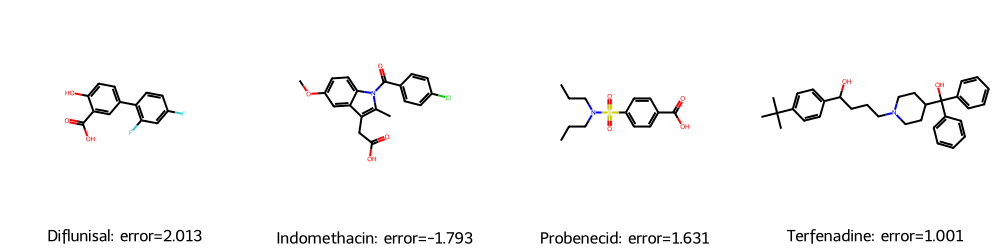

In [38]:
from rdkit.Chem import Draw
# In SolChal1, some compounds were consistently bad predicted:
# 10 - Difunisal
# 17 - Indomethacin
# 24 - Probenecid
# 29 - Terfenadine
# Paper indexes start on 1 --> [9, 16, 23, 28]

least_predicted = df_SolChal1.iloc[[9, 16, 23, 28]]
print(least_predicted[["name", "Solubility"]])
X = least_predicted[feats]
X = X.replace('', 0.0)
X = X.astype(float)
S = m.predict(X)

legends = [f"{m}: error={(s-l):>3.3f}" for m, s, l in zip(least_predicted["name"], S, least_predicted["Solubility"])]

mols = [Chem.MolFromSmiles(sml) for sml in least_predicted['SMILES']]
Draw.MolsToGridImage(
    mols, molsPerRow=4, subImgSize=(250, 250), legends=legends,
)

In [39]:
# The authors reported LogS with S as miligram/L
np.log10(SolChal1["expSolubility"])

0     2.851870
1     3.591065
2     1.326336
3     2.892095
4     0.806180
5          NaN
6     2.276232
7     1.146128
8     1.000000
9    -0.537602
10    0.539076
11         NaN
12    0.397940
13    1.292256
14    2.795880
15    1.342423
16    2.612784
17    2.195900
18    3.495544
19         NaN
20   -0.795880
21    1.461799
22         NaN
23    0.591065
24    1.287802
25    3.209515
26    2.301030
27    2.653213
28   -2.067526
29    1.819544
30    1.968483
31    2.103804
32         NaN
Name: expSolubility, dtype: float64